In [11]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import json
import nada_numpy as na
import numpy as np
import py_nillion_client as nillion
import torch
from common.utils import store_program, store_secrets
from cosmpy.aerial.client import LedgerClient
from cosmpy.aerial.wallet import LocalWallet
from cosmpy.crypto.keypairs import PrivateKey
from dotenv import load_dotenv
from nada_ai.client import TorchClient
from nillion_python_helpers import (create_nillion_client,
                                    create_payments_config)
from py_nillion_client import NodeKey, UserKey

from torch import nn
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
home = os.getenv("HOME")
load_dotenv("nada_project/.env")
print((f"{home}/.config/nillion/nillion-devnet.env"))

/home/brglt/Desktop/nillion/ETH-Online-mental-health
/home/brglt/.config/nillion/nillion-devnet.env


Dataset

In [12]:
import torch
from torch.utils.data import Dataset
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class MentalHealthDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None):
        self.data = dataframe.drop(['target', 'total_count'], axis=1)
        self.targets = dataframe['target']
        
        self.label_encoder = LabelEncoder()
        self.targets = self.label_encoder.fit_transform(self.targets)
        
        self.scaler = MinMaxScaler()
        self.data = self.scaler.fit_transform(self.data)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.data[index], dtype=torch.float32)
        label = torch.tensor(self.targets[index], dtype=torch.long)
        
        if self.transform:
            features = self.transform(features)
        
        return features, label


Network

In [13]:
import torch.nn as nn
import nada_numpy as na  # Assuming na.NadaArray usage is required by the NADA environment

class MentalHealthNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MentalHealthNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, num_classes)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x: na.NadaArray) -> na.NadaArray:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


Prepare the data

In [21]:
# Load your dataset
depression = pd.read_csv('/home/brglt/Desktop/nillion/ETH-Online-mental-health/depression_dataset.csv')

# Initialize dataset
dataset = MentalHealthDataset(depression)

# Split into train and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize model, loss function, and optimizer
input_size = dataset.data.shape[1]
num_classes = len(dataset.label_encoder.classes_)
model = MentalHealthNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

train_accuracies = []
val_accuracies = []
train_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:  # Use val_loader instead of test_loader
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")



Epoch 1/20, Loss: 1.3479, Train Accuracy: 39.10%, Val Accuracy: 53.57%
Epoch 2/20, Loss: 0.9212, Train Accuracy: 61.35%, Val Accuracy: 63.50%
Epoch 3/20, Loss: 0.7888, Train Accuracy: 65.42%, Val Accuracy: 65.68%
Epoch 4/20, Loss: 0.7251, Train Accuracy: 68.01%, Val Accuracy: 69.78%
Epoch 5/20, Loss: 0.6620, Train Accuracy: 71.18%, Val Accuracy: 73.07%
Epoch 6/20, Loss: 0.5899, Train Accuracy: 75.28%, Val Accuracy: 77.93%
Epoch 7/20, Loss: 0.5068, Train Accuracy: 80.00%, Val Accuracy: 83.25%
Epoch 8/20, Loss: 0.4226, Train Accuracy: 85.02%, Val Accuracy: 87.62%
Epoch 9/20, Loss: 0.3515, Train Accuracy: 88.85%, Val Accuracy: 90.87%
Epoch 10/20, Loss: 0.2930, Train Accuracy: 92.00%, Val Accuracy: 92.78%
Epoch 11/20, Loss: 0.2475, Train Accuracy: 93.83%, Val Accuracy: 94.97%
Epoch 12/20, Loss: 0.2142, Train Accuracy: 94.91%, Val Accuracy: 95.55%
Epoch 13/20, Loss: 0.1903, Train Accuracy: 95.50%, Val Accuracy: 96.34%
Epoch 14/20, Loss: 0.1713, Train Accuracy: 96.09%, Val Accuracy: 96.19%
E

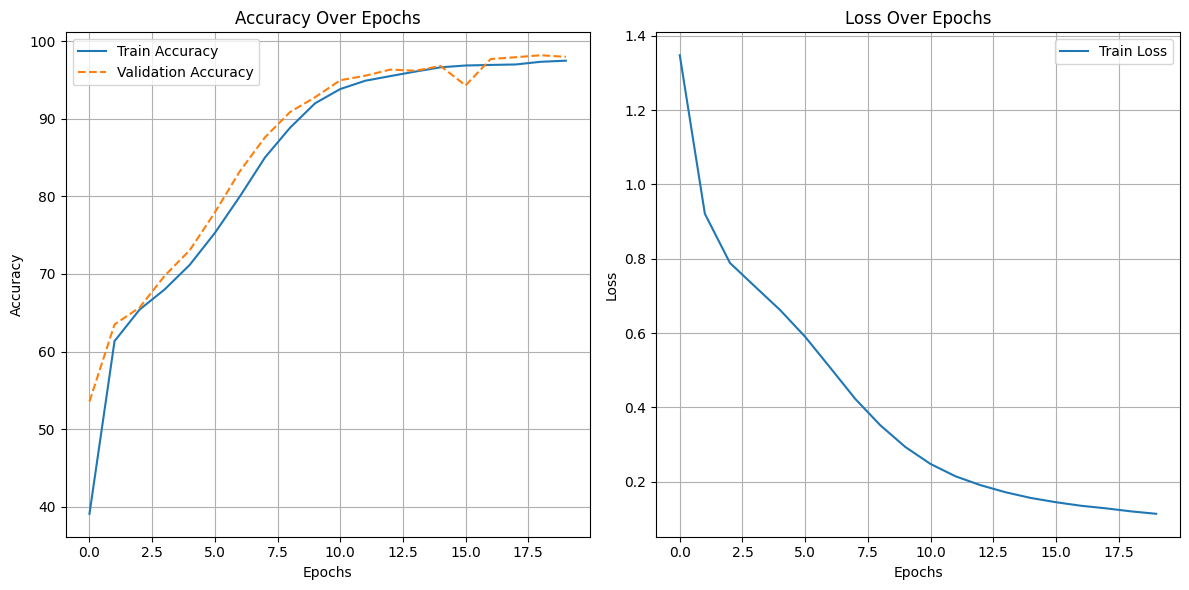

In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for training and validation accuracies
ax1.plot(train_accuracies, label='Train Accuracy')
ax1.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
ax1.set_title('Accuracy Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot for training losses
ax2.plot(train_losses, label='Train Loss')
ax2.set_title('Loss Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [23]:
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 97.58%


In [25]:

outputs= model(test_loader.dataset[0][0].unsqueeze(0))
print(outputs)
torch.argmax(outputs, axis=1)

tensor([[-19.1534,   1.5911,   3.8133, -10.7010,  -5.5316]],
       grad_fn=<AddmmBackward0>)


tensor([2])

In [27]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("precision: {:.3f}%".format(precision[1] * 100))
print("recall: {:.3f}%".format(recall[1] * 100))
print("f1: {:.3f}%".format(f1[1] * 100))
print("support: {}".format(support[1]))
print("accuracy: {}".format(epoch_accuracy))

precision: 96.099%
recall: 98.070%
f1: 97.075%
support: 829
accuracy: 97.48678675439542


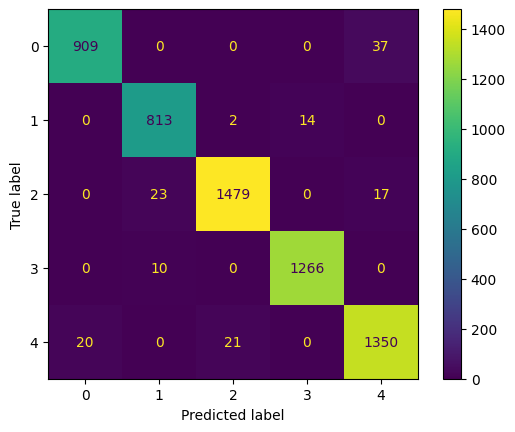

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), )
disp.plot()

## Model Provider flow

# Authenticate with Nillion

To connect to the Nillion network, we need to have a user key and a node key. These serve different purposes:

The `user_key` is the user's private key. The user key should never be shared publicly, as it unlocks access and permissions to secrets stored on the network.

The `node_key` is the node's private key which is run locally to connect to the network.

In [ ]:
# Load all Nillion network environment variables
os.getcwd()
assert os.getcwd().endswith(
    "nada_project"
), "Please run this script from the examples/multi_layer_perceptron directory otherwise, the rest of the tutorial may not work"
load_dotenv()
print(os.getenv("NILLION_CLUSTER_ID"))
dotenv_path = '/home/brglt/Desktop/nillion/ETH-Online-mental-health/nada_project/.env'
load_dotenv(dotenv_path)
print(os.getenv("NILLION_CLUSTER_ID"))